# TaskLoader tour

This notebook demonstrates how you can set up `TaskLoader` objects to load different kinds of tasks that can be used to train models that accomplish different objectives. The `TaskLoader` is very flexible and can be used to load tasks for spatial interpolation, forecasting, and downscaling, or some combination of these. The ability to use `TaskLoader`s to automatically compose ConvNP models in TensorFlow or PyTorch adds to the convenience of `deepsensor`.

In this notebook, we will demonstrate a few different tasks that can be loaded using `TaskLoader` objects. Antarctic temperature will be our target variable, using gridded ERA5 data and off-grid station data to construct tasks. However, the same principles can be applied to any other target variable and data source, as long as the data is in `xarray` or `pandas` format.

## Imports/set-up

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# import deepsensor.torch as deepsensor
# # import deepsensor.tensorflow as deepsensor

In [3]:
# from deepsensor.data.processor import DataProcessor
# from deepsensor.data.loader import TaskLoader
# from deepsensor.model.models import ConvNP
#
# from deepsensor.plot.utils import plot_context_encoding, plot_offgrid_context

In [4]:
# import pandas as pd
# import xarray as xr
#
# import matplotlib.pyplot as plt

In [5]:
import deepsensor.torch as deepsensor
# import deepsensor.tensorflow as deepsensor
from deepsensor.data.processor import DataProcessor
from deepsensor.data.loader import TaskLoader
from deepsensor.model.models import ConvNP

from deepsensor.data.loader import construct_x1x2_ds, construct_circ_time_ds
from deepsensor.model.nps import compute_encoding_tensor
from deepsensor.plot.utils import plot_context_encoding, plot_offgrid_context
import numpy as np
import pandas as pd
import xarray as xr
import dask
import json

import lab as B

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

sns.set_style("white")

from pprint import pprint
from tqdm.notebook import tqdm

if deepsensor.backend.str == "torch":
    # Run on GPU if available
    import torch

    if torch.cuda.is_available():
        # Set default GPU device
        torch.set_default_device("cuda")
        B.set_global_device("cuda:0")
elif deepsensor.backend.str == "tensorflow":
    # Run on GPU if available
    import tensorflow as tf

    if tf.test.is_gpu_available():
        # Set default GPU device
        tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
        B.set_global_device("GPU:0")
    # Check GPU visible to tf
    # print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [6]:
date = "2018-01-01"

## Load data

In [7]:
# era5_raw_ds = xr.open_mfdataset('../deepsensor_old/data/antarctica/gridded/processed/*/*.nc')
era5_raw_ds = xr.open_mfdataset('../deepsensor_old/data/antarctica/gridded/interim/tas_anom/*.nc')
era5_raw_ds

<xarray.Dataset>
Dimensions:    (time: 25933, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    t2m        (time, y, x) float32 dask.array<chunksize=(365, 280, 280), meta=np.ndarray>

In [8]:
aux_raw_ds = xr.open_mfdataset('../deepsensor_old/data/antarctica/auxiliary/interim/*25000m/*.nc')
aux_raw_ds = aux_raw_ds[['surface', 'mask']]
aux_raw_ds

<xarray.Dataset>
Dimensions:  (y: 280, x: 280)
Coordinates:
  * y        (y) float64 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    lat      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
Data variables:
    surface  (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    mask     (y, x) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [9]:
station_raw_df = pd.read_csv('../deepsensor_old/data/antarctica/station/interim/XY_station.csv')
station_raw_df = station_raw_df.rename(columns={'date': 'time'})
station_raw_df['time'] = pd.to_datetime(station_raw_df['time'])
station_raw_df = station_raw_df.set_index(['time', 'station', 'y', 'x']).sort_index()[['tas']]
station_raw_df

tas
time       station          y             x                       
1948-04-01 Macquarie_Island -3.638593e+06  1.401585e+06   5.885714
1948-04-02 Macquarie_Island -3.638593e+06  1.401585e+06   6.675000
1948-04-03 Macquarie_Island -3.638593e+06  1.401585e+06   4.775000
1948-04-04 Macquarie_Island -3.638593e+06  1.401585e+06   5.150000
1948-04-05 Macquarie_Island -3.638593e+06  1.401585e+06   4.037500
...                                                            ...
2022-06-14 Sky_Blu           5.380525e+05 -1.606516e+06 -24.912500
2022-06-15 Butler Island     9.847784e+05 -1.717203e+06 -19.669524
           Limbert           8.072843e+05 -1.351549e+06 -23.887500
           Rothera           9.270759e+05 -2.308923e+06  -9.895833
           Sky_Blu           5.380525e+05 -1.606516e+06 -26.587500

[941850 rows x 1 columns]

## Normalise data

In [10]:
data_processor = DataProcessor(x1_name='y', x1_map=(0, 3.5e6), x2_name='x', x2_map=(0, 3.5e6))

In [11]:
era5_ds, station_df = data_processor([era5_raw_ds, station_raw_df])
aux_ds = data_processor(aux_raw_ds, method="min_max")

## Let's load some tasks!

### ERA5 spatial interpolation

A spatial interapolation model can be trained by randomly sampling grid cells from `xarray` objects, which is simple to do with `TaskLoader`.

In [12]:
task_loader = TaskLoader(context=[era5_ds['t2m'], aux_ds], target=era5_ds['t2m'])
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('surface', 'mask'))
Target variable IDs: (('t2m',),)


In [13]:
model = ConvNP(data_processor, task_loader, verbose=False)
task = task_loader(date, (0.1, "all"), "all")
print(task)

time: 2018-01-01 00:00:00
flag: None
X_c: [(2, 7840), ((280,), (280,))]
Y_c: [(7840,), (2, 280, 280)]
X_t: [((280,), (280,))]
Y_t: [(1, 280, 280)]



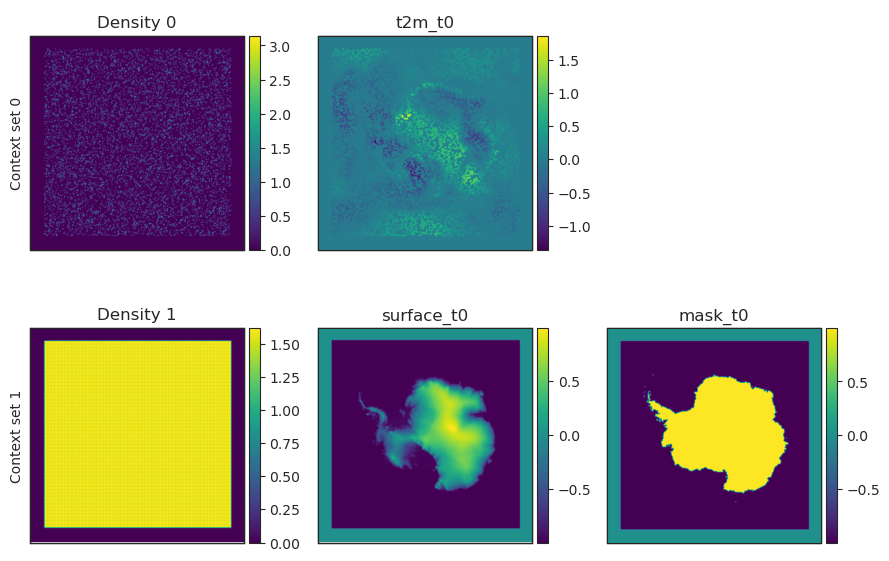

In [14]:
fig = plot_context_encoding(model, task, task_loader)
plt.show()

### Station spatial interpolation

Generating interpolation tasks from `pandas` station data is slightly more involved than with `xarray` gridded data. We must set up a 'link' between the station context set and the station target set when instantiating the `TaskLoader`. This is used for splitting the data into context and target sets when generating `Task`s from the `TaskLoader`.

In [15]:
task_loader = TaskLoader(context=[station_df, aux_ds], target=station_df, links=[(0, 0)])
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('tas',), ('surface', 'mask'))
Target variable IDs: (('tas',),)


In [16]:
model = ConvNP(data_processor, task_loader, verbose=False)
task = task_loader(date, ("split", "all"), "split", split_frac=0.7)
print(task)

time: 2018-01-01 00:00:00
flag: None
X_c: [(2, 48), ((280,), (280,))]
Y_c: [(1, 48), (2, 280, 280)]
X_t: [(2, 21)]
Y_t: [(1, 21)]



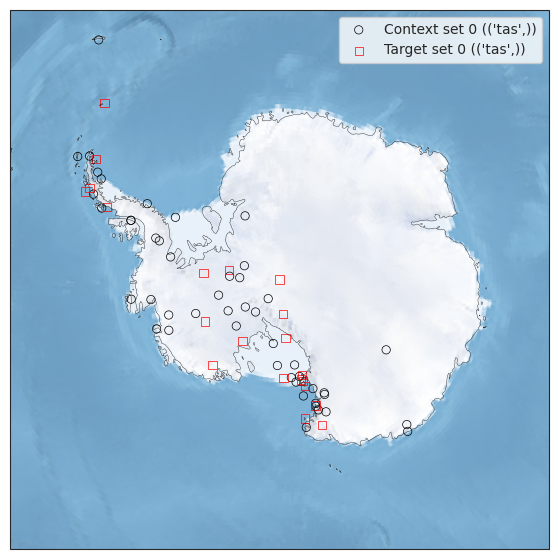

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection=ccrs.LambertAzimuthalEqualArea(0, -90)))
ax.set_extent([-3.5e6, 3.5e6, -3.5e6, 3.5e6], crs=ccrs.LambertAzimuthalEqualArea(0, -90))
ax.stock_img()
ax.coastlines(linewidth=0.25)
plot_offgrid_context(ax, task, data_processor, task_loader, plot_target=True, add_legend=True, linewidths=0.5)
plt.show()

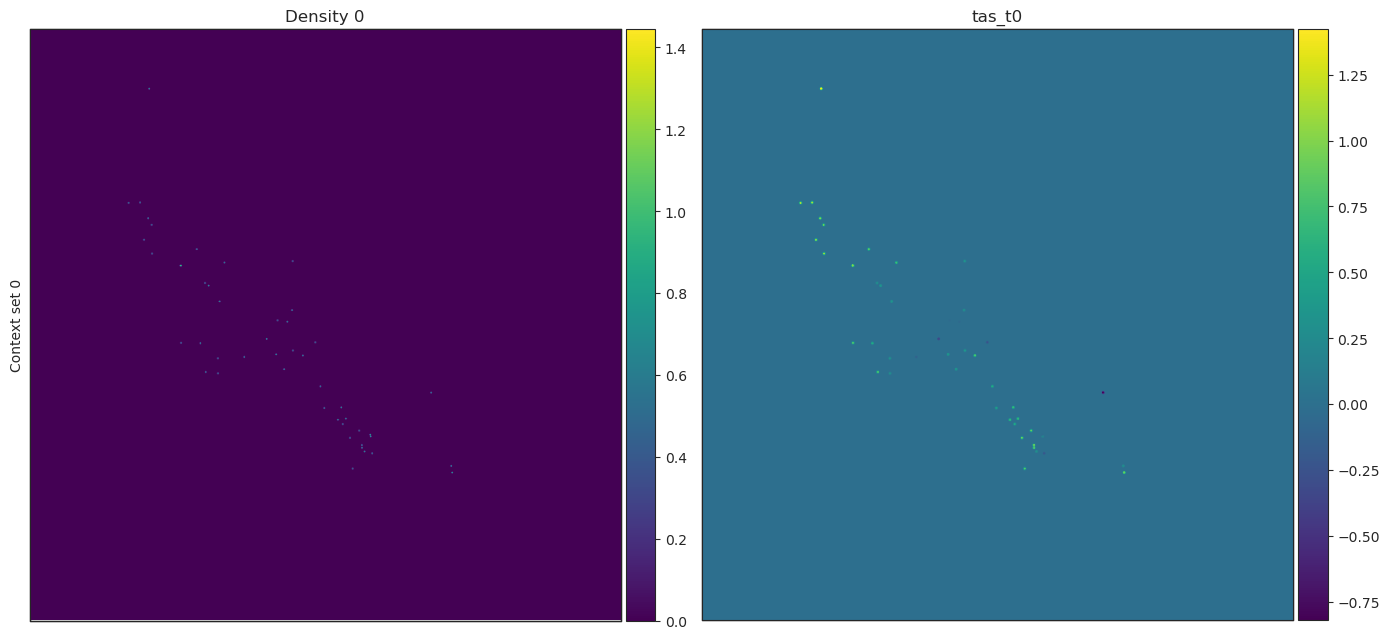

In [18]:
# Zoom-in on the station context set
fig = plot_context_encoding(model, task, task_loader, context_set_idxs=0, size=7, return_axes=True)
plt.show()

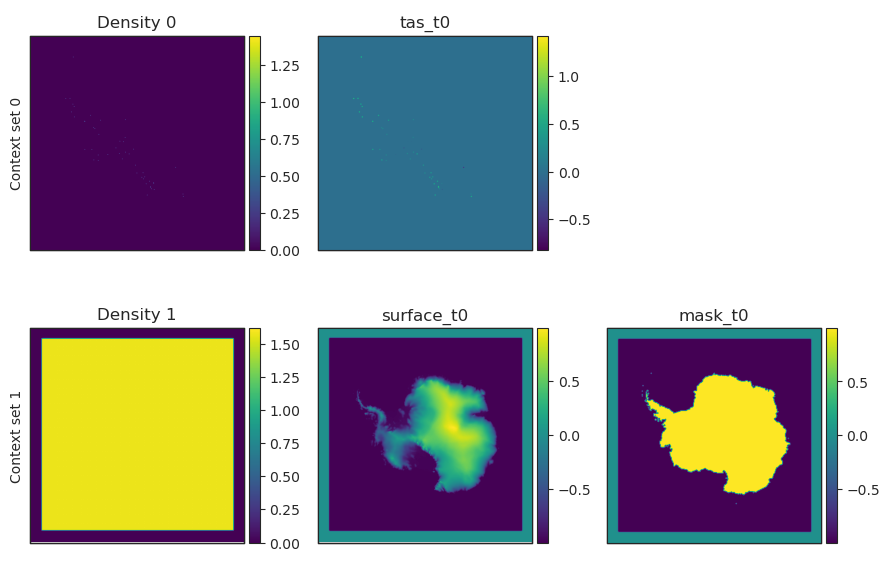

In [19]:
# Plot the whole encoding
fig = plot_context_encoding(model, task, task_loader)
plt.show()

### ERA5 forecasting

Using the `context_delta_t` and `target_delta_t` arguments, you can specify a time difference between the context and target.
In this case, we generate a task where the context is the current and previous time step and the target is the next time step.

By printing the `repr` of the `TaskLoader` object, we get more verbose variable IDs showing the time indexes of the context and target sets.

In [20]:
task_loader = TaskLoader(context=[era5_ds['t2m'], era5_ds['t2m'], aux_ds], target=era5_ds['t2m'],
                         context_delta_t=[-1, 0, 0], target_delta_t=1)
print(repr(task_loader))

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('t2m_t-1',), ('t2m_t0',), ('surface_t0', 'mask_t0'))
Target variable IDs: (('t2m_t1',),)
Context data dimensions: (1, 1, 2)
Target data dimensions: (1,)


In [21]:
model = ConvNP(data_processor, task_loader, verbose=False)
task = task_loader(date, "all", "all")
print(task)

time: 2018-01-01 00:00:00
flag: None
X_c: [((280,), (280,)), ((280,), (280,)), ((280,), (280,))]
Y_c: [(1, 280, 280), (1, 280, 280), (2, 280, 280)]
X_t: [((280,), (280,))]
Y_t: [(1, 280, 280)]



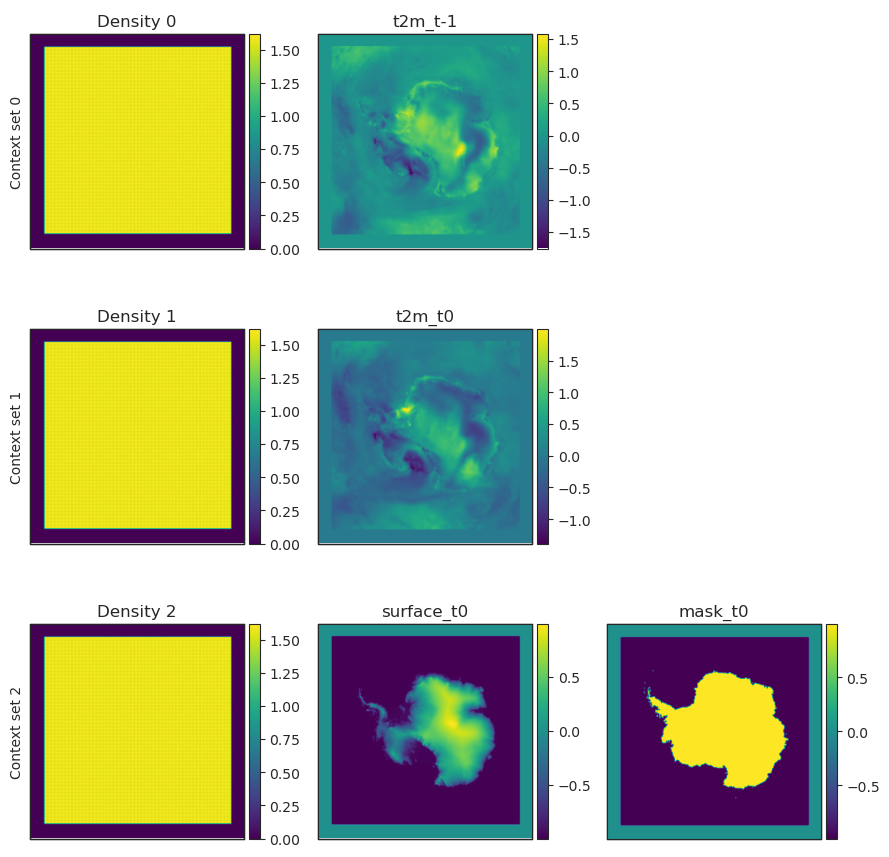

In [22]:
fig = plot_context_encoding(model, task, task_loader)
plt.show()

### ERA5 downscaling using station targets

We will also input other ERA5 variables as context to the model.

In [23]:
task_loader = TaskLoader(context=[era5_ds['t2m'], aux_ds], target=station_df)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('surface', 'mask'))
Target variable IDs: (('tas',),)


In [24]:
model = ConvNP(data_processor, task_loader, verbose=False)
task = task_loader(date, "all", "all")
print(task)

time: 2018-01-01 00:00:00
flag: None
X_c: [((280,), (280,)), ((280,), (280,))]
Y_c: [(1, 280, 280), (2, 280, 280)]
X_t: [(2, 69)]
Y_t: [(1, 69)]



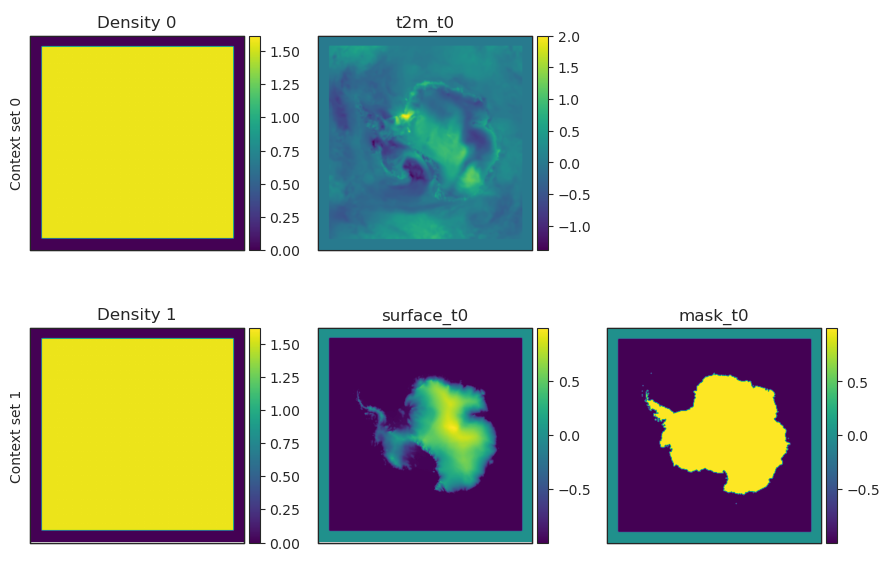

In [25]:
fig = plot_context_encoding(model, task, task_loader)
plt.show()

### TODO: Satellite data interpolation

## What's missing?

Is some functionality missing that you would like to see? Please open an issue on the [GitHub repository](https://github.com/tom-andersson/deepsensor/tree/main).

